In [ ]:
import os
import datetime
import math
import tensorflow as tf

In [ ]:
#Dataset settings
IMG_SIZE            = 256
IMG_CHANNELS        = 1
BATCH_SIZE          = 32
PREFETCH_N          = 4
SHUFFLE_BUFFER_SIZE = 512
TRAIN_PERCENT       = 80
TEST_PERCENT        = 10
VAL_PERCENT         = 10

In [ ]:
#Load dataset
dataset = tf.data.experimental.load("drive/MyDrive/dataset_marcin_new.tf")
NR_OF_IMAGES        = len(dataset)
NR_OF_TRAIN_IMAGES  = math.floor(NR_OF_IMAGES * (TRAIN_PERCENT / 100))
NR_OF_VAL_IMAGES    = math.ceil(NR_OF_IMAGES * (VAL_PERCENT / 100))
NR_OF_TEST_IMAGES   = math.ceil(NR_OF_IMAGES * (TEST_PERCENT / 100))

In [ ]:
#Training settings
EPOCHS = 50
STEPS_PER_EPOCH = 500
VALIDATION_STEPS = 25

In [ ]:
#Logs and callbacks
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
checkpoint_filepath = "checkpoint/a/{epoch}"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    save_weights_only = True,
    monitor = "acc",
    mode = "max",
    save_best_only = False
)

stop_callback = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5)

In [ ]:
def prepare(image, label):
  image = tf.cast(image, dtype=tf.float32)
  image = (image / 255) - 0.5
  return image, label

In [ ]:
train = dataset.take(NR_OF_TRAIN_IMAGES).shuffle(SHUFFLE_BUFFER_SIZE)
valid = dataset.skip(NR_OF_TRAIN_IMAGES).take(NR_OF_VAL_IMAGES)
test = dataset.skip(NR_OF_TRAIN_IMAGES+NR_OF_VAL_IMAGES).take(NR_OF_TEST_IMAGES)

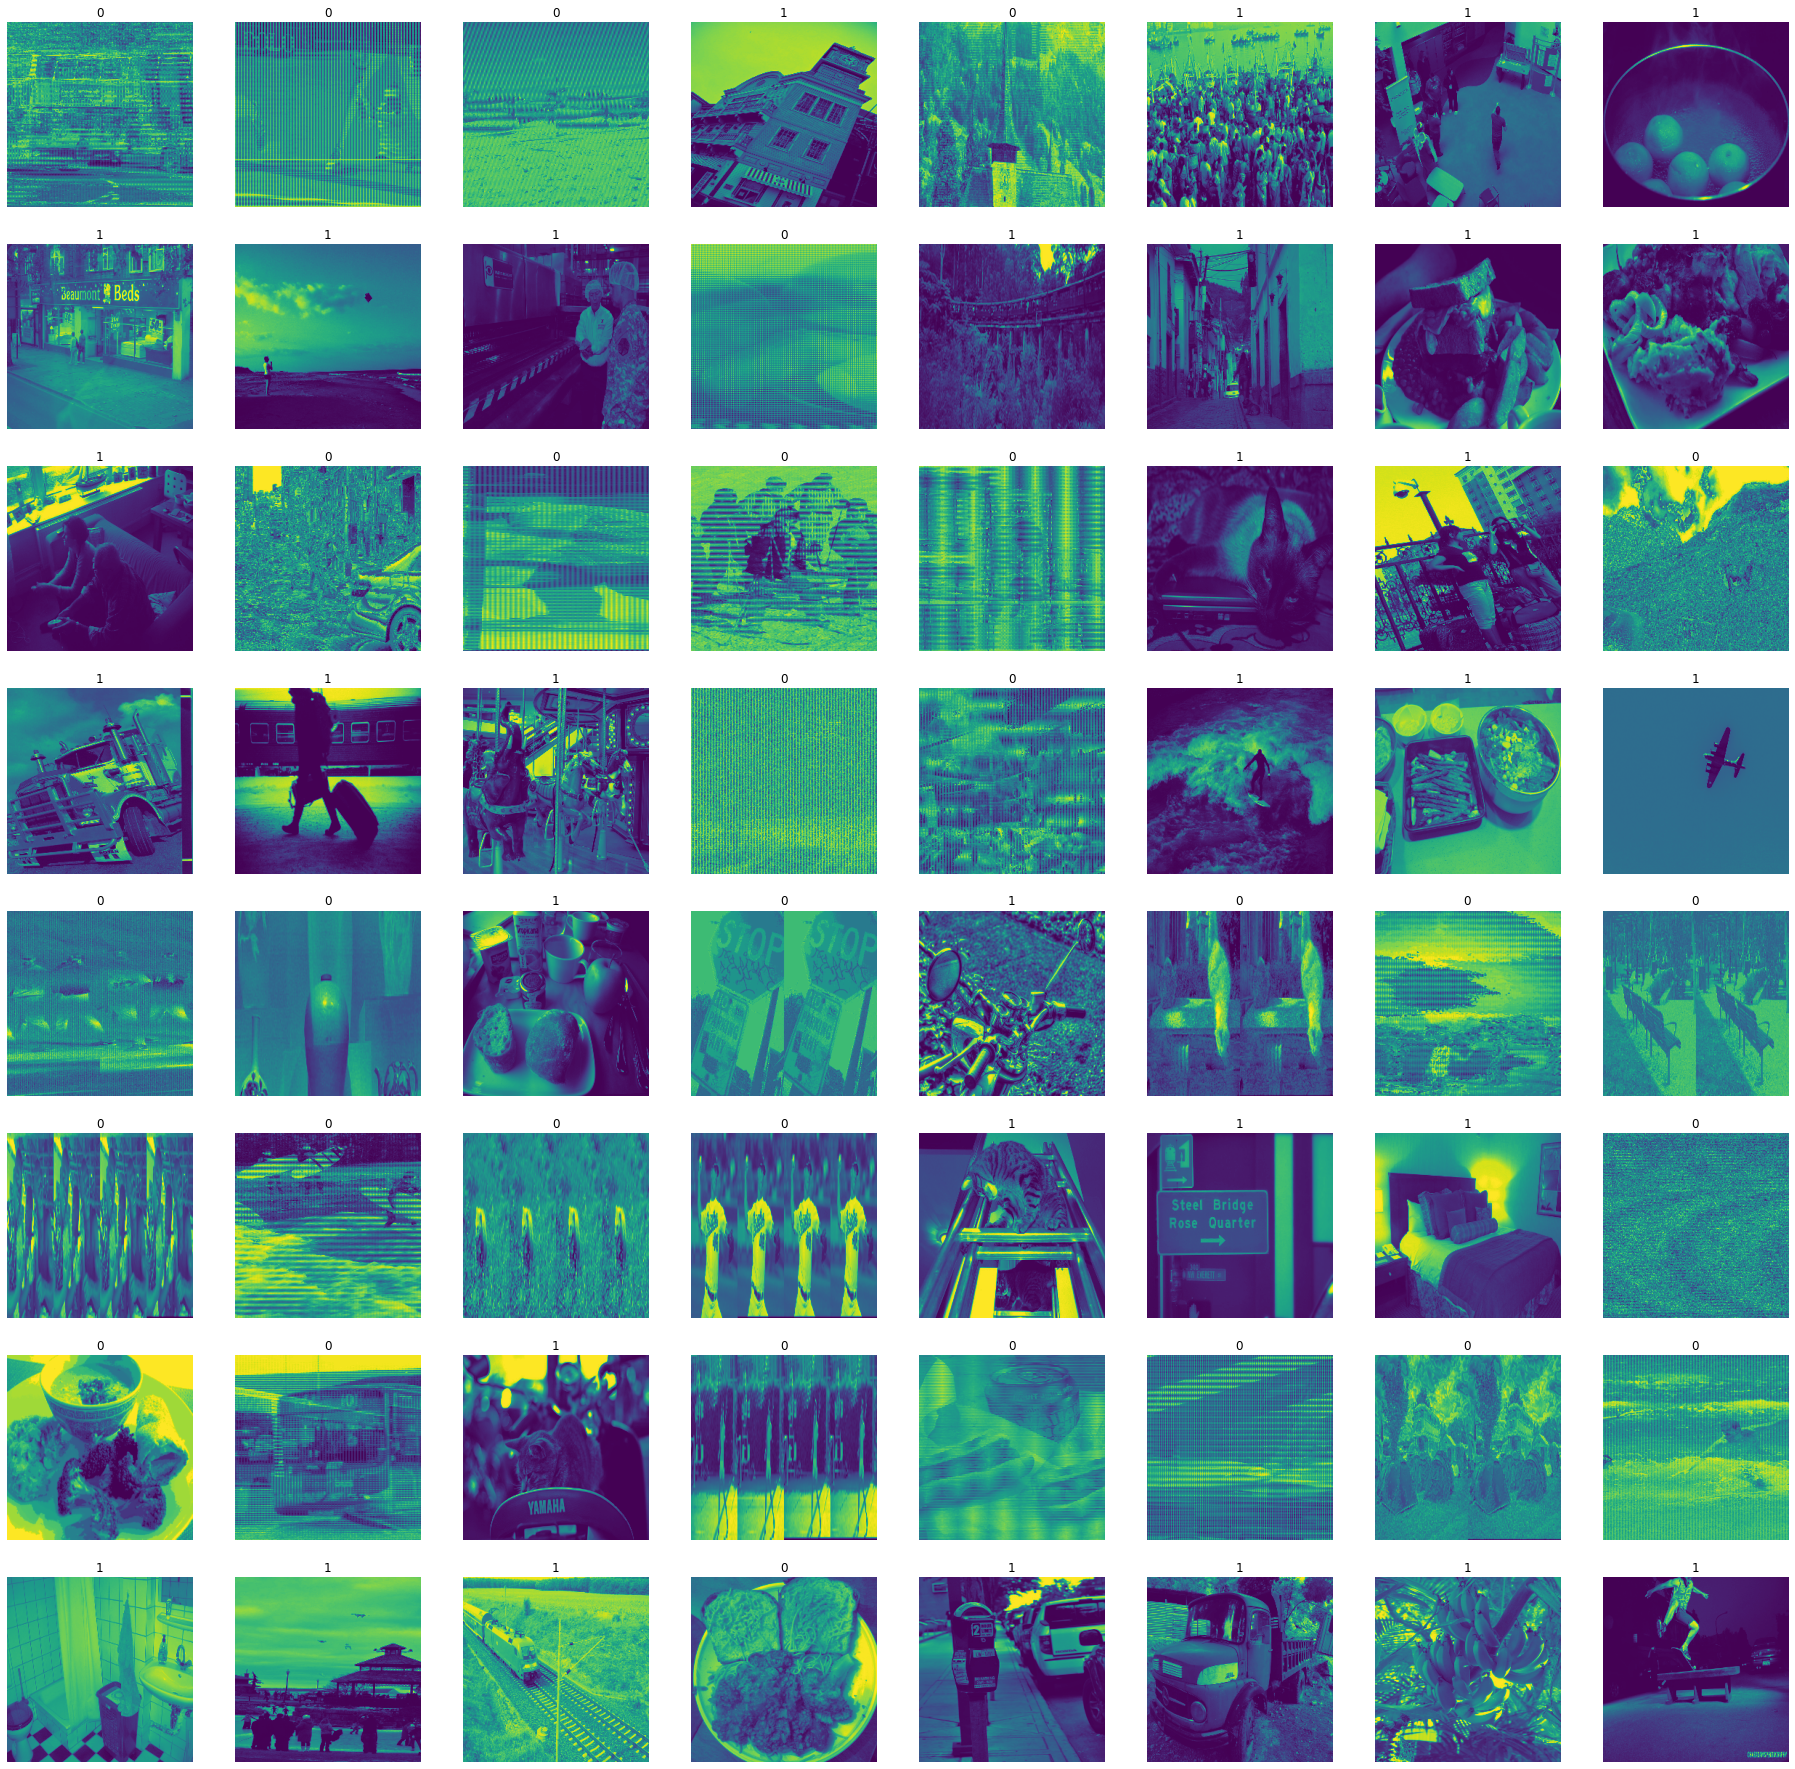

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(32, 32))
i = 0
for images, labels in train.take(64):
    ax = plt.subplot(8, 8, i+1)
    img = images[:, :, 0]
    plt.imshow(img.numpy().astype("uint8"))
    plt.title(labels.numpy())
    plt.axis("off")
    i += 1

In [ ]:
train_batches = train.batch(BATCH_SIZE).map(prepare, num_parallel_calls=tf.data.AUTOTUNE).cache().prefetch(tf.data.AUTOTUNE)
valid_batches = valid.batch(BATCH_SIZE).map(prepare, num_parallel_calls=tf.data.AUTOTUNE).cache().prefetch(tf.data.AUTOTUNE)
test_batches = test.batch(BATCH_SIZE).map(prepare, num_parallel_calls=tf.data.AUTOTUNE).cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(tf.keras.layers.MaxPool2D((2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same"))
model.add(tf.keras.layers.MaxPool2D((2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Conv2D(128, (3,3), activation="relu", padding="same"))
model.add(tf.keras.layers.MaxPool2D((2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation="relu"))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(128, activation="relu"))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [ ]:
model.compile(
    loss = "binary_crossentropy",
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics = [tf.keras.metrics.BinaryAccuracy()]
)

In [ ]:
model.fit(
    epochs = EPOCHS,
    x = train_batches,
    steps_per_epoch = STEPS_PER_EPOCH,
    validation_data = valid_batches,
    validation_steps = VALIDATION_STEPS,
    callbacks = [tensorboard_callback, model_checkpoint_callback, stop_callback]
)

In [ ]:
results = []
for i in range(1, EPOCHS + 1):
    try:
        model.load_weights(f"checkpoint/a/{i}")
        result = model.evaluate(test_batches)
        results.append(result[1])
    except:
        break

In [ ]:
best = results.index(max(results)) + 1
print(f"Acc: {max(results)} Best epoch: {best}")
model.load_weights(f"checkpoint/a/{best}")
model.save("drive/MyDrive/model_formats.h5")